In [ ]:
import os
import numpy as np
import matplotlib.pyplot as plt
import cv2
import tensorflow as tf
from keras.preprocessing.image import ImageDataGenerator
from keras.models import load_model, Model
from keras.layers import Dense, GlobalAveragePooling2D, Dropout
from keras.applications.convnext import ConvNeXtTiny

# Download and unzip the dataset from Kaggle
!kaggle datasets download -d omkargurav/face-mask-dataset
!unzip face-mask-dataset.zip -d face-mask-dataset

In [12]:
# Directory paths
base_dir = 'face-mask-dataset/data'
train_dir = os.path.join(base_dir)
validation_dir = os.path.join(base_dir)

# Data augmentation and preprocessing
train_datagen = ImageDataGenerator(
    rescale=1.0/255.0,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest',
    validation_split=0.2  # 20% for validation
)

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(128, 128),
    batch_size=32,
    class_mode='binary',
    subset='training'
)

validation_generator = train_datagen.flow_from_directory(
    validation_dir,
    target_size=(128, 128),
    batch_size=32,
    class_mode='binary',
    subset='validation'
)

# Load ConvNeXtTiny model
base_model = ConvNeXtTiny(weights='imagenet', include_top=False, input_shape=(128, 128, 3))

# Add custom layers on top of ConvNeXtTiny
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation='relu')(x)
x = Dropout(0.5)(x)  # Add dropout layer
predictions = Dense(1, activation='sigmoid')(x)

model = Model(inputs=base_model.input, outputs=predictions)

# Freeze all layers of the base model
for layer in base_model.layers:
    layer.trainable = False

# Compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])


Streaming output truncated to the last 5000 lines.
  inflating: face-mask-dataset/data/with_mask/with_mask_3299.jpg  
  inflating: face-mask-dataset/data/with_mask/with_mask_33.jpg  
  inflating: face-mask-dataset/data/with_mask/with_mask_330.jpg  
  inflating: face-mask-dataset/data/with_mask/with_mask_3300.jpg  
  inflating: face-mask-dataset/data/with_mask/with_mask_3301.jpg  
  inflating: face-mask-dataset/data/with_mask/with_mask_3302.jpg  
  inflating: face-mask-dataset/data/with_mask/with_mask_3303.jpg  
  inflating: face-mask-dataset/data/with_mask/with_mask_3304.jpg  
  inflating: face-mask-dataset/data/with_mask/with_mask_3305.jpg  
  inflating: face-mask-dataset/data/with_mask/with_mask_3306.jpg  
  inflating: face-mask-dataset/data/with_mask/with_mask_3307.jpg  
  inflating: face-mask-dataset/data/with_mask/with_mask_3308.jpg  
  inflating: face-mask-dataset/data/with_mask/with_mask_3309.jpg  
  inflating: face-mask-dataset/data/with_mask/with_mask_331.jpg  
  inflating: fa

In [13]:
# Train the model
history = model.fit(
    train_generator,
    epochs=10,
    validation_data=validation_generator
)

# Save the trained model
model.save('face_mask_model_convnexttiny_dropout.h5')

Epoch 1/10
  6/189 [..............................] - ETA: 27s - loss: 1.0089 - accuracy: 0.5000

/usr/local/lib/python3.10/dist-packages/PIL/Image.py:996: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


189/189 [==============================] - 65s 290ms/step - loss: 0.6409 - accuracy: 0.6477 - val_loss: 0.6433 - val_accuracy: 0.5987
Epoch 2/10
189/189 [==============================] - 50s 266ms/step - loss: 0.5584 - accuracy: 0.7089 - val_loss: 0.6428 - val_accuracy: 0.6152
Epoch 3/10
189/189 [==============================] - 49s 262ms/step - loss: 0.5412 - accuracy: 0.7159 - val_loss: 0.6079 - val_accuracy: 0.6318
Epoch 4/10
189/189 [==============================] - 51s 271ms/step - loss: 0.5248 - accuracy: 0.7308 - val_loss: 0.6380 - val_accuracy: 0.6265
Epoch 5/10
189/189 [==============================] - 49s 257ms/step - loss: 0.5206 - accuracy: 0.7293 - val_loss: 0.6006 - val_accuracy: 0.6411
Epoch 6/10
189/189 [==============================] - 48s 256ms/step - loss: 0.5188 - accuracy: 0.7321 - val_loss: 0.6066 - val_accuracy: 0.6430
Epoch 7/10
189/189 [==============================] - 48s 256ms/step - loss: 0.5053 - accuracy: 0.7412 - val_loss: 0.6112 - val_accuracy: 0.6

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [14]:
test_loss, test_acc = model.evaluate(validation_generator)
print(f"Test accuracy: {test_acc}")


48/48 [==============================] - 9s 193ms/step - loss: 0.5786 - accuracy: 0.6530
Test accuracy: 0.6529801487922668


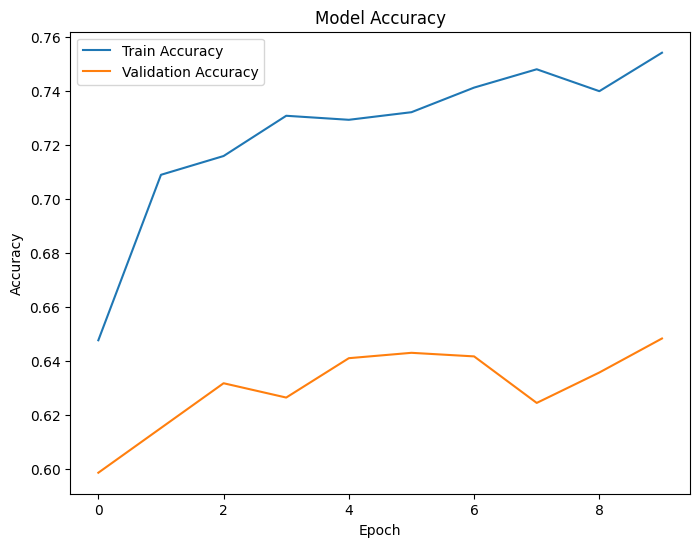

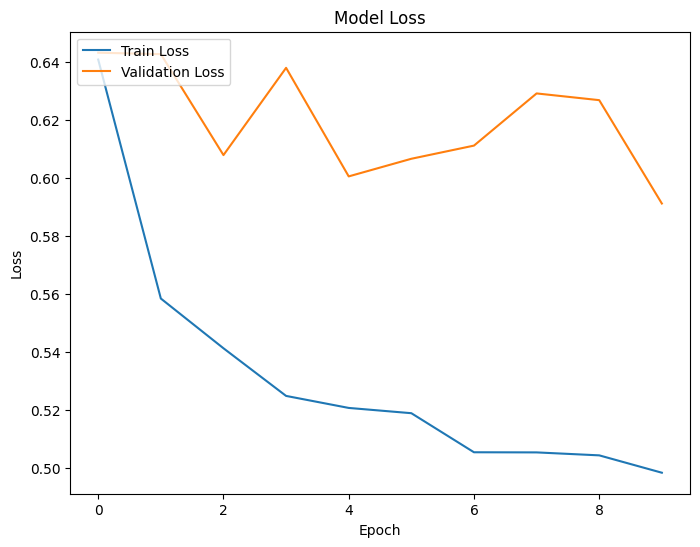

In [15]:
# Plot training & validation accuracy values
plt.figure(figsize=(8, 6))
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='upper left')
plt.show()

# Plot training & validation loss values
plt.figure(figsize=(8, 6))
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(loc='upper left')
plt.show()

In [17]:
from tensorflow.keras.layers import Layer
import tensorflow as tf


class LayerScale(Layer):
    def __init__(self, init_values=1e-6, projection_dim=None, **kwargs):
        super(LayerScale, self).__init__(**kwargs)
        self.init_values = init_values
        self.projection_dim = projection_dim

    def build(self, input_shape):
        self.gamma = self.add_weight(
            shape=(self.projection_dim,),
            initializer=tf.keras.initializers.Constant(self.init_values),
            trainable=True,
            name='gamma'
        )

    def call(self, inputs):
        return inputs * self.gamma

    def get_config(self):
        config = super(LayerScale, self).get_config()
        config.update({
            'init_values': self.init_values,
            'projection_dim': self.projection_dim,
        })
        return confi

1/1 [==============================] - 4s 4s/step


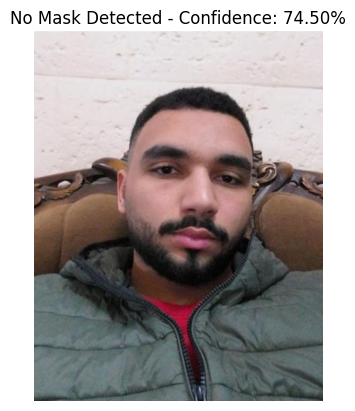

1/1 [==============================] - 0s 37ms/step


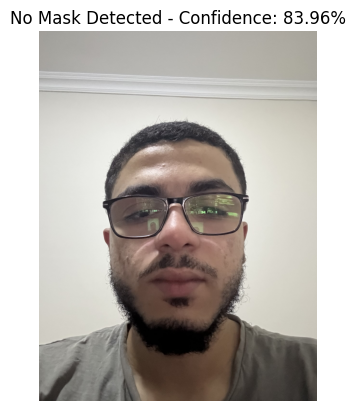

1/1 [==============================] - 0s 45ms/step


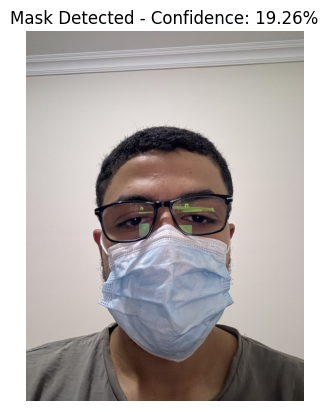

1/1 [==============================] - 0s 40ms/step


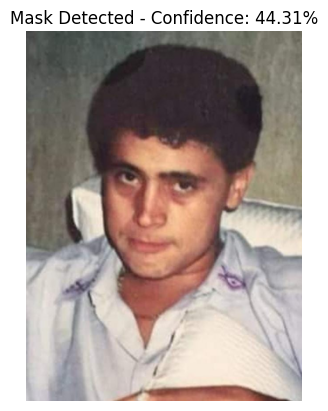

In [29]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.models import load_model
from tensorflow.keras.utils import custom_object_scope

# Define the LayerScale class (as shown above)
# (Include the LayerScale class definition here)

# Load the trained model with custom object scope
with custom_object_scope({'LayerScale': LayerScale}):
    model = load_model('/content/face_mask_model_convnexttiny_dropout.h5')

# Function to preprocess the input image
def preprocess_image(image_path):
    img = cv2.imread(image_path)
    img = cv2.resize(img, (128, 128))
    img = np.expand_dims(img, axis=0)
    img = img / 255.0  # Normalize
    return img

# Function to make predictions on multiple images
def predict_images(image_paths):
    for image_path in image_paths:
        preprocessed_img = preprocess_image(image_path)
        prediction = model.predict(preprocessed_img)
        confidence_percentage = prediction[0][0] * 100
        if prediction < 0.5:
            label = "Mask Detected"
        else:
            label = "No Mask Detected"
        image = cv2.imread(image_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        plt.imshow(image)
        plt.axis('off')
        plt.title(f'{label} - Confidence: {confidence_percentage:.2f}%')
        plt.show()

image_paths = ["/content/disha.jpeg", "/content/amr.jpg", "/content/amrmask.jpg", "/content/john.jpeg"]
predict_images(image_paths)


48/48 [==============================] - 16s 202ms/step
              precision    recall  f1-score   support

   with_mask       0.48      0.32      0.38       745
without_mask       0.50      0.66      0.57       765

    accuracy                           0.49      1510
   macro avg       0.49      0.49      0.48      1510
weighted avg       0.49      0.49      0.48      1510



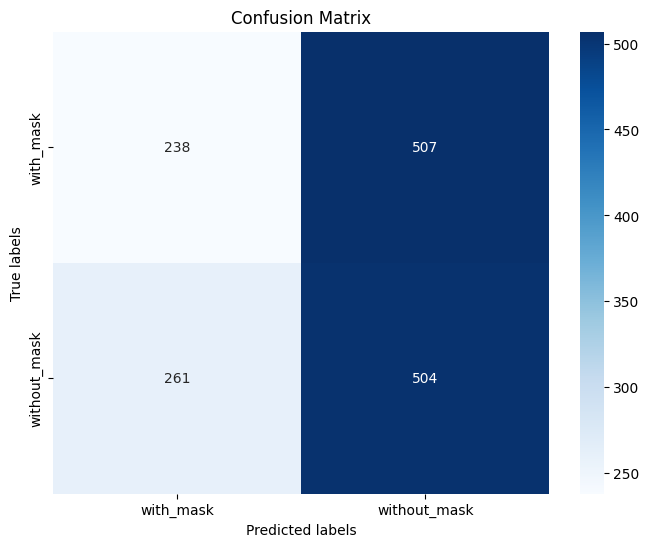

In [25]:
from sklearn.metrics import classification_report

# Evaluate the model on the validation data
validation_generator.reset()
predictions = model.predict(validation_generator, steps=len(validation_generator), verbose=1)

# Convert probabilities to class labels
predicted_classes = (predictions > 0.5).astype('int32')
true_classes = validation_generator.classes

# Generate classification report
class_labels = list(validation_generator.class_indices.keys())
report = classification_report(true_classes, predicted_classes, target_names=class_labels)

print(report)
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Generate confusion matrix
conf_matrix = confusion_matrix(true_classes, predicted_classes)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix')
plt.show()
